<a href="https://www.kaggle.com/code/darvack/transformer-paper-regression2?scriptVersionId=135212899" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
random.seed(42)
np.random.seed(42)

Here, we have loaded the data and set Furan as the label.
At first, we have used KFold Round-Robin for testing our model so that every data points gets tested 1 time.

In [2]:
ds_A = pd.read_csv("/kaggle/input/transformer/DatasetA.csv").sample(frac=1, random_state=42).reset_index(drop=True)
ds_B = pd.read_csv("/kaggle/input/transformer/DatasetB.csv").sample(frac=1, random_state=42).reset_index(drop=True)


y_A = ds_A['Furan']
X_A = ds_A.drop(["Furan", "HI"], axis=1)

y_B = ds_B['Furan']
X_B = ds_B.drop(["Furan", "HI"], axis=1)

y_stratify = pd.DataFrame(y_A.copy())
bins = [-1, 0.1, 1, 100]
labels = [0, 1, 2]
y_stratify['Class'] = pd.cut(y_stratify['Furan'], bins=bins, labels=labels)
y_stratify = y_stratify.drop(["Furan"], axis=1)

In [3]:
#ds_A.hist(bins=50, figsize=(20,15))

The code below, drops the columns that we don't need, and only keeps the common features between dataset A and B.

In [4]:
X_A = X_A.drop(set(ds_A.columns) - set(ds_B.columns), axis=1)
X_B = X_B[X_A.columns]
X_A

,H2,Methane,Acetylene,Ethylene,Ethane,Water,Acid,BDV,IFT
0,22.6,0.0,0.0,0.5,0.7,6,0.005,51.0,30
1,8.9,5.1,2.7,2.9,3.3,24,0.019,36.0,26
2,13.4,14.8,0.0,1.4,2.2,3,0.005,77.0,31
3,18.5,12.4,0.0,0.9,3.2,8,0.005,51.0,32
4,19.9,31.0,0.0,2.1,26.8,3,0.005,80.0,32
...,...,...,...,...,...,...,...,...,...
725,13.9,2.1,0.0,1.1,2.1,6,0.026,73.0,27
726,42.5,4.7,0.0,1.0,2.0,3,0.005,68.0,37
727,12.7,12.7,0.0,0.3,1.2,5,0.005,81.0,36
728,10.3,0.5,0.0,0.0,0.0,5,0.005,51.0,35


The code below performs feature selection via step-wise regression or SequentialFeatureSelector. "n_features_to_select" is a hyperparameter that defines how many feature we'd like to keep which needs to be fine tuned. In our experiment, 6 or 7 features to keep, results in better models.

In [5]:
'''from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

for i in range(1,9):
    rf_reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)
    
    xgb_reg = XGBRegressor(learning_rate=0.01, n_estimators=300, max_depth=3, subsample=0.7)

    sfs = SequentialFeatureSelector(rf_reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())
'''

useful_features1 = ['IFT']
useful_features2 = ['Methane', 'IFT']
useful_features3 = ['Methane', 'Ethane', 'IFT']
useful_features4 = ['Methane', 'Ethane', 'Water', 'IFT']
useful_features5 = ['Methane', 'Ethylene', 'Ethane', 'BDV', 'IFT']
useful_features6 = ['Methane', 'Ethylene', 'Ethane', 'Water', 'BDV', 'IFT']
useful_features7 = ['H2', 'Methane', 'Acetylene', 'Ethylene', 'Ethane', 'BDV', 'IFT']
useful_features8 = ['H2', 'Methane', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [6]:
Selectedfeatures5= ['H2', 'Ethane', 'Water', 'Acid', 'IFT']
Selectedfeatures6 = ['H2', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

# Removing outliers

In [7]:
# For Dataset A
means = X_A.mean()
stds = X_A.std()

# Identify outliers 
outliers_A = X_A[(np.abs(X_A - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_A = X_A[~X_A.index.isin(outliers_A.index)]
y_A = y_A[~y_A.index.isin(outliers_A.index)]


# For Dataset B:
means = X_B.mean()
stds = X_B.std()

# Identify outliers 
outliers_B = X_B[(np.abs(X_B - means) > 3 * stds).any(axis=1)]

# Remove outliers 
X_B = X_B[~X_B.index.isin(outliers_B.index)]
y_B = y_B[~y_B.index.isin(outliers_B.index)]

# Standard Scaling

In [8]:
X_A = (X_A - X_A.mean())/X_A.std()
X_B = (X_B - X_B.mean())/X_B.std()

# Correlation Matrix and Mutual Information

<Axes: >

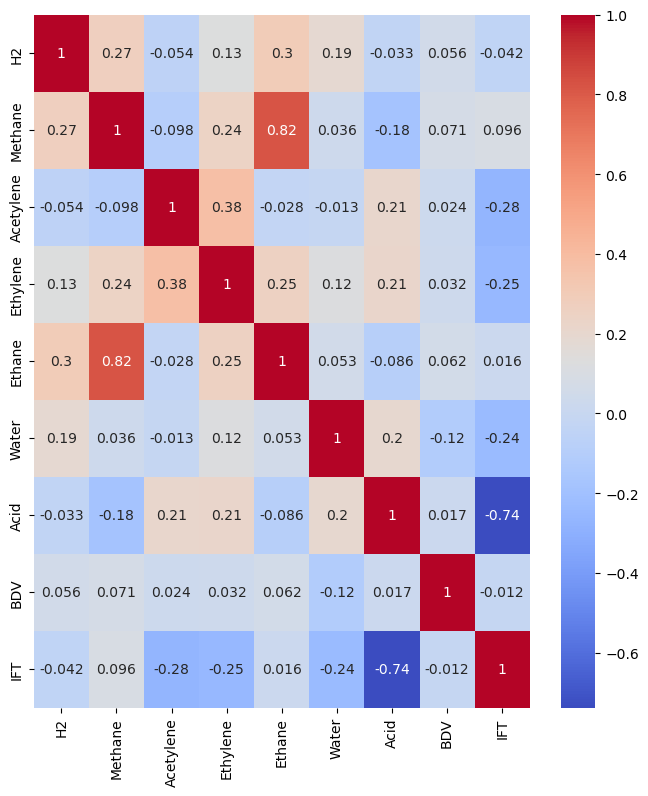

In [9]:
corr_matrix = X_A.corr()
import seaborn as sns
plt.figure(figsize=(8, 9))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm')

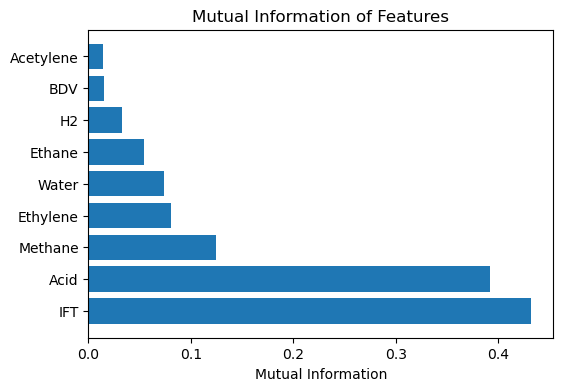

In [10]:
from sklearn.feature_selection import mutual_info_regression

# Compute the mutual information between all pairs of columns
mi_matrix = mutual_info_regression(X_A, y_A, random_state=0)

# Convert the mutual information scores to a DataFrame
mi_df = pd.DataFrame(mi_matrix, index=X_A.columns, columns=['Mutual Information'])

# Sort the DataFrame by mutual information score in descending order
mi_df = mi_df.sort_values(by=['Mutual Information'], ascending=False)

# Plot the mutual information scores as a horizontal bar chart
plt.figure(figsize=(6, 4))
plt.barh(mi_df.index, mi_df['Mutual Information'])
plt.xlabel('Mutual Information')
plt.title('Mutual Information of Features')
plt.show()

# First case: Training using 75% of the data and testing on the remaining 25% with Round-Robin (KFold)

Importing libraries

In [11]:
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import AdaBoostRegressor
from catboost import CatBoostRegressor
import lightgbm as lgb

Here is a comparison of different models.

**Trying Bagging Regressor:**

In [12]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble import BaggingRegressor

scoring = 'neg_mean_squared_error'
base_estimator = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)

# Define the Pasting algorithm with 5 estimators
reg = BaggingRegressor(estimator=base_estimator, max_samples=0.75, max_features=1.0, bootstrap=True, random_state=42, n_estimators=10)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

BaggingRegressor for dataset A:
MSE Scores: [0.59444711 0.16222633 0.2068412  0.23451131]
Mean MSE: 0.2995064889087748


**Random forest model**

In [13]:
reg = RandomForestRegressor(min_samples_split=12, min_samples_leaf=1, random_state=42)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A with feature selection:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

RandomForestRegressor for dataset A:
MSE Scores: [0.57398357 0.17878687 0.17469908 0.27275149]
Mean MSE: 0.30005525157362456
RandomForestRegressor for dataset A with feature selection:
MSE Scores: [0.57510367 0.17856504 0.15801583 0.27847814]
Mean MSE: 0.29754066992262085
MSE Score for dataset B: 0.7066290176942751
MSE Score for dataset B with feature selection: 0.6208493165812511


In [14]:
reg = AdaBoostRegressor(random_state=42, n_estimators=200, learning_rate=0.003)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

AdaBoostRegressor for dataset A:
MSE Scores: [0.6765929  0.17044313 0.21250842 0.31193636]
Mean MSE: 0.3428702035330903
AdaBoostRegressor for dataset A:
MSE Scores: [0.66881749 0.18725453 0.19510538 0.32278084]
Mean MSE: 0.3434895571618888
MSE Score for dataset B: 0.7706172118093417
MSE Score for dataset B with feature selection: 0.5796439238266107


In [15]:
reg = XGBRegressor(random_state=42, learning_rate=0.005, n_estimators=300, max_depth=5, subsample=0.95)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

XGBRegressor for dataset A:
MSE Scores: [0.74534419 0.22863584 0.15455421 0.19373817]
Mean MSE: 0.3305681017138328
XGBRegressor for dataset A:
MSE Scores: [0.72748262 0.22962797 0.14804586 0.20623863]
Mean MSE: 0.3278487711618608
MSE Score for dataset B: 0.5340828008057905
MSE Score for dataset B with feature selection: 0.6074162480835626


In [16]:
reg = CatBoostRegressor(iterations=100, learning_rate=0.04, verbose=0, depth=8, loss_function='RMSE', random_seed=42)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

CatBoostRegressor for dataset A:
MSE Scores: [0.75668156 0.16429703 0.17224511 0.17987231]
Mean MSE: 0.3182740051217416
CatBoostRegressor for dataset A:
MSE Scores: [0.71716744 0.16222405 0.15473672 0.18149244]
Mean MSE: 0.30390516144208685
MSE Score for dataset B: 0.5583504828876631
MSE Score for dataset B with feature selection: 0.5558883874961643


In [17]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors=5,metric='euclidean')

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

KNeighborsRegressor for dataset A:
MSE Scores: [0.62995614 0.16496179 0.21238804 0.2275418 ]
Mean MSE: 0.30871194365115956
KNeighborsRegressor for dataset A:
MSE Scores: [0.63400546 0.16739758 0.16656141 0.2532884 ]
Mean MSE: 0.30531321192410366
MSE Score for dataset B: 0.7348768593711329
MSE Score for dataset B with feature selection: 0.6517713654013012


In [18]:
from sklearn.neighbors import KNeighborsRegressor

reg = KNeighborsRegressor(n_neighbors=10)

scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores:", mse_scores)
print("Mean MSE:", mse_scores.mean())

reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print("MSE Score for dataset B:", mean_squared_error(y_B, y_pred_B))

reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print("MSE Score for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

KNeighborsRegressor for dataset A:
MSE Scores: [0.66510641 0.14388776 0.20209754 0.21425635]
Mean MSE: 0.3063370144287421
KNeighborsRegressor for dataset A:
MSE Scores: [0.67321707 0.16038938 0.18219359 0.21736459]
Mean MSE: 0.3082911605921822
MSE Score for dataset B: 0.6521801313804869
MSE Score for dataset B with feature selection: 0.640181594297625


# Stacking Model:
This model consists of ridge regression, AdaBoost, Bayesian ARD regression and a random forest model. It takes the output of these models and stack their cross-validation to form the training set of a meta-model. The meta-model train on this new dataset and outputs the final prediction.

The features below are selected by step-wise regression.

In [19]:
Selectedfeatures1 = ['Acid']
Selectedfeatures2 = ['Water', 'Acid']
Selectedfeatures3 = ['Ethane', 'Water', 'Acid']
Selectedfeatures4 = ['Ethane', 'Water', 'Acid', 'IFT']
Selectedfeatures5 = ['Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures6 = ['Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures7 = ['H2', 'Acetylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']
Selectedfeatures8 = ['H2', 'Acetylene', 'Ethylene', 'Ethane', 'Water', 'Acid', 'BDV', 'IFT']

In [20]:
from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit

estimators = [('ridge', Ridge(alpha=1)),
              ('ada', AdaBoostRegressor(random_state=41, n_estimators=200, learning_rate=0.003)),
              ('adr', ARDRegression()),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = Ridge(alpha=0.01)

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

# Testing dataset A without Feature selection
scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores without feature selection:", mse_scores)
print("Mean MSE without feature selection:", mse_scores.mean())

# Testing dataset A with Feature selection
scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores with feature selection:", mse_scores)
print("Mean MSE with feature selection:", mse_scores.mean())

# Testing dataset B without Feature Selection
reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print(reg.__class__.__name__ + " for dataset B without feature selection:", mean_squared_error(y_B, y_pred_B))

# Testing dataset B with Feature selection
reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print(reg.__class__.__name__ + " for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset A:
MSE Scores without feature selection: [0.55634966 0.2409569  0.19754358 0.25579414]
Mean MSE without feature selection: 0.3126610693800316
StackingRegressor for dataset A:
MSE Scores with feature selection: [0.53172601 0.19245461 0.19010351 0.26641357]
Mean MSE with feature selection: 0.2951744226535336
StackingRegressor for dataset B without feature selection: 0.6828089188830303
StackingRegressor for dataset B with feature selection: 0.5769878300767768


In [21]:
# TESTTTTTTTTTTTTTTTTTTTTT

from sklearn.linear_model import RidgeCV, LassoCV, ElasticNetCV, Ridge, Lasso, ElasticNet
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import BayesianRidge
from sklearn.linear_model import ARDRegression
from sklearn.model_selection import StratifiedShuffleSplit

estimators = [#('ridge', Ridge(alpha=1)),
              ('ada', AdaBoostRegressor(random_state=41, n_estimators=200, learning_rate=0.003)),
              ('bay', BayesianRidge()),
              ('knn', KNeighborsRegressor(n_neighbors=5)),
              ('rf', RandomForestRegressor(min_samples_split=2, min_samples_leaf=1, random_state=41))
             ]

final_estimator = Ridge(alpha=1)

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator, cv=5)

# Testing dataset A without Feature selection
scores = cross_val_score(reg, X_A, y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores without feature selection:", mse_scores)
print("Mean MSE without feature selection:", mse_scores.mean())

# Testing dataset A with Feature selection
scores = cross_val_score(reg, X_A[Selectedfeatures7], y_A, cv=4, scoring=scoring)
mse_scores = -scores
print(reg.__class__.__name__ + " for dataset A:")
print("MSE Scores with feature selection:", mse_scores)
print("Mean MSE with feature selection:", mse_scores.mean())

# Testing dataset B without Feature Selection
reg.fit(X_A, y_A)
y_pred_B = reg.predict(X_B)
print(reg.__class__.__name__ + " for dataset B without feature selection:", mean_squared_error(y_B, y_pred_B))

# Testing dataset B with Feature selection
reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print(reg.__class__.__name__ + " for dataset B with feature selection:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset A:
MSE Scores without feature selection: [0.54225607 0.18862951 0.18946095 0.23606492]
Mean MSE without feature selection: 0.2891028638288612
StackingRegressor for dataset A:
MSE Scores with feature selection: [0.52880021 0.1572691  0.1671099  0.25339113]
Mean MSE with feature selection: 0.27664258420278426
StackingRegressor for dataset B without feature selection: 0.6938670340955057
StackingRegressor for dataset B with feature selection: 0.5808229368332892


In [22]:
reg.fit(X_A[useful_features6], y_A)
y_pred_B = reg.predict(X_B[useful_features6])
print(reg.__class__.__name__ + " for dataset B:", mean_squared_error(y_B, y_pred_B))

StackingRegressor for dataset B: 0.5808229368332892


In [23]:
'''from sklearn.feature_selection import SequentialFeatureSelector
from catboost import CatBoostRegressor
from xgboost import XGBRegressor
from sklearn.ensemble import RandomForestRegressor

reg = StackingRegressor(
    estimators=estimators, final_estimator=final_estimator)

for i in range(1,9):
    sfs = SequentialFeatureSelector(reg,
                                    n_features_to_select=i,
                                    direction='backward',
                                    scoring='neg_mean_squared_error',
                                    cv=4)

    sfs.fit(X_A, y_A)

    # Print the selected features
    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'''

'from sklearn.feature_selection import SequentialFeatureSelector\nfrom catboost import CatBoostRegressor\nfrom xgboost import XGBRegressor\nfrom sklearn.ensemble import RandomForestRegressor\n\nreg = StackingRegressor(\n    estimators=estimators, final_estimator=final_estimator)\n\nfor i in range(1,9):\n    sfs = SequentialFeatureSelector(reg,\n                                    n_features_to_select=i,\n                                    direction=\'backward\',\n                                    scoring=\'neg_mean_squared_error\',\n                                    cv=4)\n\n    sfs.fit(X_A, y_A)\n\n    # Print the selected features\n    print("Selected features" + f"{i}:", sfs.get_feature_names_out())'